The new version, with alternative better baselines. 
1. EfficientNet for Image Embeddings 
2. Clinical Bert for Text Embeddings

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import json
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add modules to path
sys.path.append('modules')

# Import our custom utilities
from data_utils import load_processed_data_v2, create_data_loaders, plot_training_history, plot_confusion_matrix
from model_utils import CNNBaseline, train_model, evaluate_model, EfficientNetBaseline, EarlyStopping

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



In [8]:
# Load preprocessed data
train_df, val_df, test_df, label_encoder, config = load_processed_data_v2()
print(f"Data loaded: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test samples")

try:
    tfidf_embeddings = np.load('embeddings/tfidf_embeddings.npy')
    print(f"TF-IDF embeddings loaded: {tfidf_embeddings.shape}")

    # Try to load BioClinicalBERT embeddings if available
    try:
        bert_embeddings = np.load('embeddings/BioClinical_embeddings.npy')
        print(f"BioClinicalBERT embeddings loaded: {bert_embeddings.shape}")
    except FileNotFoundError:
        bert_embeddings = None
        print("BioClinicalBERT embeddings not found, using TF-IDF only")

except FileNotFoundError:
    print("Text embeddings not found.")
    raise



Data loaded: 945 train, 315 val, 315 test samples
TF-IDF embeddings loaded: (2298, 128)
BioClinicalBERT embeddings loaded: (1575, 768)


In [5]:
# Load EfficientNet results ## This needed to be loaded from prev experiments, 
    # however, the json werenot saved properly. So we will just hardcode the best results here.
effnetModel = {}

effnetModel['best_model'] = 'efficient_net_base_best.pth'
effnetModel['best_accuracy'] = 0.8635


In [6]:
class MultimodalFusionClassifier(nn.Module):
    def __init__(self, image_model, text_embedding_dim=768, num_classes=2, fusion_type='concat'):
        super(MultimodalFusionClassifier, self).__init__()
        self.image_model = image_model
        self.fusion_type = fusion_type
        
        # Freeze or unfreeze image model as needed
        for param in self.image_model.parameters():
            param.requires_grad = False  # freezing baselines
        
        # Output dimension from image model
        image_embedding_dim = 128
        
        # Fusion logic
        if fusion_type == 'concat':
            fusion_input_dim = image_embedding_dim + text_embedding_dim
        elif fusion_type == 'sum':
            assert image_embedding_dim == text_embedding_dim, "Dims must match for sum fusion"
            fusion_input_dim = image_embedding_dim
        else:
            raise ValueError(f"Unknown fusion type: {fusion_type}")
        
        # Fusion layers
        self.classifier = nn.Sequential(
            nn.Linear(fusion_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, text_embedding):
        # image: [batch, 3, H, W]
        # text_embedding: [batch, text_embedding_dim]
        image_embedding = self.image_model(image)  # [batch, 128]
        fused = torch.cat((image_embedding, text_embedding), dim=1)
        output = self.classifier(fused)
        return output


In [9]:
# Create Multimodal Dataset
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, df, text_embeddings, image_dirs, transform=None):
        self.df = df.reset_index(drop=True)
        self.text_embeddings = text_embeddings
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['img_id']
        
        # Load image
        img = None
        for part, dir_path in self.image_dirs.items():
            full_path = os.path.join('archive', dir_path, img_id)
            if os.path.exists(full_path):
                try:
                    from PIL import Image
                    img = Image.open(full_path).convert('RGB')
                    break
                except Exception as e:
                    continue
        
        if img is None:
            img = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            img = self.transform(img)
        
        # Get text embedding
        text_embedding = torch.FloatTensor(self.text_embeddings[idx])
        
        # Get target
        target = row['diagnostic']
        
        return img, text_embedding, target

In [10]:
IMAGE_DIRS = {
    'part1': 'imgs_part_1/imgs_part_1',
    'part2': 'imgs_part_2/imgs_part_2', 
    'part3': 'imgs_part_3/imgs_part_3'
}

In [11]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
# Create datasets
train_dataset = MultimodalDataset(train_df, bert_embeddings[:len(train_df)], IMAGE_DIRS, train_transform)
val_dataset = MultimodalDataset(val_df, bert_embeddings[len(train_df):len(train_df)+len(val_df)], IMAGE_DIRS, val_transform)
test_dataset = MultimodalDataset(test_df, bert_embeddings[len(train_df)+len(val_df):], IMAGE_DIRS, val_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")
print(f"Text embedding dim: {bert_embeddings.shape[1]}")


Train: 945 samples
Val: 315 samples
Test: 315 samples
Text embedding dim: 768


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficient_baseline = EfficientNetBaseline()

In [ ]:


fused_model = MultimodalFusionClassifier(
    image_model = efficient_baseline,
    text_embedding_dim=bert_embeddings.shape[1],
    num_classes=2,
    fusion_type='concat'
)

print(f"Parameters: {sum(p.numel() for p in fused_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in fused_model.parameters() if p.requires_grad):,}")


Parameters: 8,127,556
Trainable parameters: 246,210


In [12]:
fused_model = fused_model.to(device)


In [ ]:
# Training function for multimodal model
def train_multimodal_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
        
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, text_embeddings, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            
            # Encode targets if they are strings
            if label_encoder is not None:
                targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
            else:
                targets = torch.tensor(targets, dtype=torch.long)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, text_embeddings)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, text_embeddings, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images = images.to(device)
                text_embeddings = text_embeddings.to(device)
                
                if label_encoder is not None:
                    targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
                else:
                    targets = torch.tensor(targets, dtype=torch.long)
                targets = targets.to(device)
                
                outputs = model(images, text_embeddings)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'models/multimodal_best.pth')
            print(f'New best model saved! Val Acc: {val_acc:.2f}%')
    
    return history


In [15]:
multimodal_history = train_multimodal_model(
    model=fused_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=0.001,
    device='cuda'
)

print("Multimodal training complete.")

Epoch 1/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Epoch 1/10:
  Train Loss: 0.6990, Train Acc: 50.16%
  Val Loss: 0.6934, Val Acc: 51.11%
New best model saved! Val Acc: 51.11%


Epoch 2/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Epoch 2/10:
  Train Loss: 0.6899, Train Acc: 54.29%
  Val Loss: 0.6887, Val Acc: 59.05%
New best model saved! Val Acc: 59.05%


Epoch 3/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch 3/10:
  Train Loss: 0.6893, Train Acc: 53.97%
  Val Loss: 0.6866, Val Acc: 53.65%


Epoch 4/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 4/10:
  Train Loss: 0.6842, Train Acc: 54.39%
  Val Loss: 0.6818, Val Acc: 56.51%


Epoch 5/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Epoch 5/10:
  Train Loss: 0.6786, Train Acc: 56.93%
  Val Loss: 0.6754, Val Acc: 59.68%
New best model saved! Val Acc: 59.68%


Epoch 6/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Epoch 6/10:
  Train Loss: 0.6703, Train Acc: 58.10%
  Val Loss: 0.6702, Val Acc: 59.05%


Epoch 7/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Epoch 7/10:
  Train Loss: 0.6628, Train Acc: 59.37%
  Val Loss: 0.6635, Val Acc: 61.90%
New best model saved! Val Acc: 61.90%


Epoch 8/10 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch 8/10:
  Train Loss: 0.6603, Train Acc: 60.95%
  Val Loss: 0.6574, Val Acc: 63.81%
New best model saved! Val Acc: 63.81%


Epoch 9/10 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Epoch 9/10:
  Train Loss: 0.6515, Train Acc: 61.48%
  Val Loss: 0.6568, Val Acc: 64.76%
New best model saved! Val Acc: 64.76%


Epoch 10/10 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

Epoch 10/10:
  Train Loss: 0.6553, Train Acc: 61.69%
  Val Loss: 0.6557, Val Acc: 64.76%
Multimodal training complete.


The metrics still don't look so good, but this was quite expected.
1. First of all, the text are generated from metadata, which doesn't really directly may relate to the target ( 'diagnostic' ).
2. Had there been a good dataset of texts and images relating to the 'diagnostic', the result would surely be better.
3. Text embeddings generated by BioClinicalBert is of 768 dimensions even though textual data isn't the main factor of diagnostics and from the Image Encoder, which actually should be the primary contributor to output is of only 128 dimensions. Thus, text embeddings are overshadowing the model, confusing it.



- Image embeddings → 128-dim, and highly informative (diagnostic visual cues).

- Text embeddings → 768-dim, but weakly correlated with target (mostly metadata).

- Current fusion (concat) → 768 + 128 = 896-dim vector → text dominates learning, model confuses signals.

### Projecting both Image Encoder and Text Encoder to the same dimensions ( possibly even making text embeddings to lower dimension ). ( So that the text embedding doesn't overweigh in the model ).

## A Hybrid Image Dominant Fusion Approach

In [17]:
import torch.nn.functional as F

class HybridImageDominantFusion(nn.Module):
    def __init__(
        self,
        image_model,
        text_embedding_dim=768,
        image_embedding_dim=128,
        reduced_text_dim=64,
        num_classes=2,
        image_weight=0.75,  
        fusion_type='weighted'    ## this is preferred
    ):
        super(HybridImageDominantFusion, self).__init__()
        self.image_model = image_model
        self.image_weight = image_weight
        self.fusion_type = fusion_type

        # Image Encoder
        for param in self.image_model.parameters():
            param.requires_grad = False  # freeze image model (or unfreeze later for fine-tuning)

    
        # compress text embeddings to smaller dimension ( projecting text embeddings to lower dim)
        self.text_projector = nn.Sequential(
            nn.Linear(text_embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, reduced_text_dim),
            nn.ReLU()
        )

        # Fusion logic
        # If concat, we just join both
        if fusion_type == 'concat':
            fusion_input_dim = image_embedding_dim + reduced_text_dim
        elif fusion_type == 'weighted':
            # both projected to same dim to allow weighted sum
            self.image_projection = nn.Linear(image_embedding_dim, reduced_text_dim)
            fusion_input_dim = reduced_text_dim
        else:
            raise ValueError(f"Unknown fusion type: {fusion_type}")

        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(fusion_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, text_embedding):
        # Get image and text representations
        image_embedding = self.image_model(image)         # [batch, 128]
        text_embedding = self.text_projector(text_embedding)  # [batch, reduced_text_dim]

        if self.fusion_type == 'concat':
            # Concatenate but text is already low-dimensional
            fused = torch.cat((image_embedding, text_embedding), dim=1)

        elif self.fusion_type == 'weighted':
            # Project image embedding to same dim as text for weighted fusion
            image_proj = self.image_projection(image_embedding)  # [batch, reduced_text_dim]

            # Weighted hybrid fusion: image dominant
            fused = self.image_weight * image_proj + (1 - self.image_weight) * text_embedding

        output = self.classifier(fused)
        return output


In [18]:
model = HybridImageDominantFusion(
    image_model=efficient_baseline,
    text_embedding_dim=bert_embeddings.shape[1],
    image_embedding_dim=128,
    reduced_text_dim=32,
    num_classes=2,
    image_weight=0.8,
    fusion_type='weighted'
)


In [23]:
def train_hybrid_multimodal_model(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    learning_rate=0.001,
    device='cuda',
    label_encoder=None,
    early_stopping=None
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'val_precision': [], 'val_recall': []
    }

    best_val_f1 = 0.0
    best_val_acc = 0.0   

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        all_train_preds, all_train_targets = [], []

        for images, text_embeddings, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images, text_embeddings = images.to(device), text_embeddings.to(device)

            if label_encoder is not None:
                targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
            else:
                targets = torch.tensor(targets, dtype=torch.long)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, text_embeddings)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.detach().cpu().numpy())
            all_train_targets.extend(targets.detach().cpu().numpy())

        # Training metrics
        train_loss /= len(train_loader)
        train_acc = 100 * (np.array(all_train_preds) == np.array(all_train_targets)).mean()
        train_f1 = f1_score(all_train_targets, all_train_preds, average='weighted')

        # Validation
        model.eval()
        val_loss = 0.0
        all_val_preds, all_val_targets = [], []

        with torch.no_grad():
            for images, text_embeddings, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                images, text_embeddings = images.to(device), text_embeddings.to(device)

                if label_encoder is not None:
                    targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
                else:
                    targets = torch.tensor(targets, dtype=torch.long)
                targets = targets.to(device)

                outputs = model(images, text_embeddings)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.detach().cpu().numpy())
                all_val_targets.extend(targets.detach().cpu().numpy())

        # Validation metrics
        val_loss /= len(val_loader)
        val_acc = 100 * (np.array(all_val_preds) == np.array(all_val_targets)).mean()
        val_precision = precision_score(all_val_targets, all_val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_val_targets, all_val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_val_targets, all_val_preds, average='weighted')

        # Log metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        scheduler.step()

        # Epoch summary
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"  Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, F1: {train_f1:.4f}")
        print(f"  Val   -> Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, "
              f"Prec: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Save best models
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'models/hybrid_multimodal_best_f1.pth')
            print(f"Saved best F1 model! (Val F1: {val_f1:.4f})")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'models/hybrid_multimodal_best_acc.pth')
            print(f"Saved best Accuracy model! (Val Acc: {val_acc:.2f}%)")


        if early_stopping is not None:
            stop = early_stopping(val_loss, model)
            if stop:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

    print(f"\nTraining complete. Best Val F1: {best_val_f1:.4f}")
    return history


In [24]:
early_stopping = EarlyStopping(patience=7)
hybrid_history = train_hybrid_multimodal_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=0.001,
    device='cuda',
    label_encoder=label_encoder,
    early_stopping=early_stopping
)

Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]



Epoch [1/50]
  Train -> Loss: 0.6889, Acc: 53.23%, F1: 0.4721
  Val   -> Loss: 0.6844, Acc: 53.65%, Prec: 0.2878, Recall: 0.5365, F1: 0.3747
Saved best F1 model! (Val F1: 0.3747)
Saved best Accuracy model! (Val Acc: 53.65%)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]



Epoch [2/50]
  Train -> Loss: 0.6787, Acc: 54.07%, F1: 0.3895
  Val   -> Loss: 0.6692, Acc: 60.32%, Prec: 0.6519, Recall: 0.6032, F1: 0.5439
Saved best F1 model! (Val F1: 0.5439)
Saved best Accuracy model! (Val Acc: 60.32%)


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch [3/50]
  Train -> Loss: 0.6640, Acc: 60.32%, F1: 0.5739
  Val   -> Loss: 0.6329, Acc: 70.48%, Prec: 0.7057, Recall: 0.7048, F1: 0.7050
Saved best F1 model! (Val F1: 0.7050)
Saved best Accuracy model! (Val Acc: 70.48%)


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]



Epoch [4/50]
  Train -> Loss: 0.6508, Acc: 63.17%, F1: 0.6312
  Val   -> Loss: 0.6303, Acc: 62.22%, Prec: 0.6565, Recall: 0.6222, F1: 0.6125


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]



Epoch [5/50]
  Train -> Loss: 0.6386, Acc: 62.54%, F1: 0.6253
  Val   -> Loss: 0.6059, Acc: 70.16%, Prec: 0.7059, Recall: 0.7016, F1: 0.7019


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]



Epoch [6/50]
  Train -> Loss: 0.6275, Acc: 64.76%, F1: 0.6480
  Val   -> Loss: 0.5975, Acc: 70.48%, Prec: 0.7044, Recall: 0.7048, F1: 0.7045


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]



Epoch [7/50]
  Train -> Loss: 0.6357, Acc: 63.07%, F1: 0.6292
  Val   -> Loss: 0.6018, Acc: 69.21%, Prec: 0.6976, Recall: 0.6921, F1: 0.6923


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]



Epoch [8/50]
  Train -> Loss: 0.6359, Acc: 64.34%, F1: 0.6417
  Val   -> Loss: 0.6030, Acc: 70.16%, Prec: 0.7019, Recall: 0.7016, F1: 0.7017


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]



Epoch [9/50]
  Train -> Loss: 0.6352, Acc: 64.02%, F1: 0.6391
  Val   -> Loss: 0.6062, Acc: 70.48%, Prec: 0.7113, Recall: 0.7048, F1: 0.7049


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



Epoch [10/50]
  Train -> Loss: 0.6124, Acc: 66.14%, F1: 0.6610
  Val   -> Loss: 0.5839, Acc: 71.43%, Prec: 0.7138, Recall: 0.7143, F1: 0.7138
Saved best F1 model! (Val F1: 0.7138)
Saved best Accuracy model! (Val Acc: 71.43%)


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it]



Epoch [11/50]
  Train -> Loss: 0.6121, Acc: 67.72%, F1: 0.6769
  Val   -> Loss: 0.5823, Acc: 71.43%, Prec: 0.7144, Recall: 0.7143, F1: 0.7125


Epoch 12/50 [Val]: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]



Epoch [12/50]
  Train -> Loss: 0.6162, Acc: 65.82%, F1: 0.6569
  Val   -> Loss: 0.5851, Acc: 71.75%, Prec: 0.7172, Recall: 0.7175, F1: 0.7161
Saved best F1 model! (Val F1: 0.7161)
Saved best Accuracy model! (Val Acc: 71.75%)


Epoch 13/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



Epoch [13/50]
  Train -> Loss: 0.6396, Acc: 63.07%, F1: 0.6301
  Val   -> Loss: 0.5930, Acc: 71.43%, Prec: 0.7144, Recall: 0.7143, F1: 0.7125


Epoch 14/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]



Epoch [14/50]
  Train -> Loss: 0.6235, Acc: 65.71%, F1: 0.6550
  Val   -> Loss: 0.5866, Acc: 69.84%, Prec: 0.7009, Recall: 0.6984, F1: 0.6988


Epoch 15/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch [15/50]
  Train -> Loss: 0.6306, Acc: 66.24%, F1: 0.6611
  Val   -> Loss: 0.5882, Acc: 70.79%, Prec: 0.7109, Recall: 0.7079, F1: 0.7036


Epoch 16/50 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]



Epoch [16/50]
  Train -> Loss: 0.6127, Acc: 66.35%, F1: 0.6604
  Val   -> Loss: 0.5807, Acc: 70.16%, Prec: 0.7013, Recall: 0.7016, F1: 0.7014


Epoch 17/50 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]



Epoch [17/50]
  Train -> Loss: 0.6007, Acc: 67.20%, F1: 0.6715
  Val   -> Loss: 0.5764, Acc: 71.11%, Prec: 0.7121, Recall: 0.7111, F1: 0.7084


Epoch 18/50 [Val]: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]



Epoch [18/50]
  Train -> Loss: 0.6075, Acc: 65.71%, F1: 0.6562
  Val   -> Loss: 0.5755, Acc: 70.48%, Prec: 0.7049, Recall: 0.7048, F1: 0.7048


Epoch 19/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]



Epoch [19/50]
  Train -> Loss: 0.6210, Acc: 65.93%, F1: 0.6577
  Val   -> Loss: 0.5819, Acc: 70.48%, Prec: 0.7042, Recall: 0.7048, F1: 0.7036


Epoch 20/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]



Epoch [20/50]
  Train -> Loss: 0.6135, Acc: 65.71%, F1: 0.6562
  Val   -> Loss: 0.5854, Acc: 69.84%, Prec: 0.6986, Recall: 0.6984, F1: 0.6985


Epoch 21/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]



Epoch [21/50]
  Train -> Loss: 0.6133, Acc: 66.77%, F1: 0.6657
  Val   -> Loss: 0.5827, Acc: 71.75%, Prec: 0.7186, Recall: 0.7175, F1: 0.7148


Epoch 22/50 [Val]: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]



Epoch [22/50]
  Train -> Loss: 0.6154, Acc: 67.20%, F1: 0.6715
  Val   -> Loss: 0.5812, Acc: 70.16%, Prec: 0.7013, Recall: 0.7016, F1: 0.7014


Epoch 23/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]



Epoch [23/50]
  Train -> Loss: 0.6343, Acc: 62.22%, F1: 0.6209
  Val   -> Loss: 0.5841, Acc: 72.70%, Prec: 0.7282, Recall: 0.7270, F1: 0.7246
Saved best F1 model! (Val F1: 0.7246)
Saved best Accuracy model! (Val Acc: 72.70%)


Epoch 24/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]



Epoch [24/50]
  Train -> Loss: 0.6035, Acc: 67.94%, F1: 0.6757
  Val   -> Loss: 0.5786, Acc: 72.06%, Prec: 0.7208, Recall: 0.7206, F1: 0.7189


Epoch 25/50 [Val]: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Epoch [25/50]
  Train -> Loss: 0.6349, Acc: 63.81%, F1: 0.6368
  Val   -> Loss: 0.5838, Acc: 71.11%, Prec: 0.7113, Recall: 0.7111, F1: 0.7091

Early stopping triggered at epoch 25

Training complete. Best Val F1: 0.7246


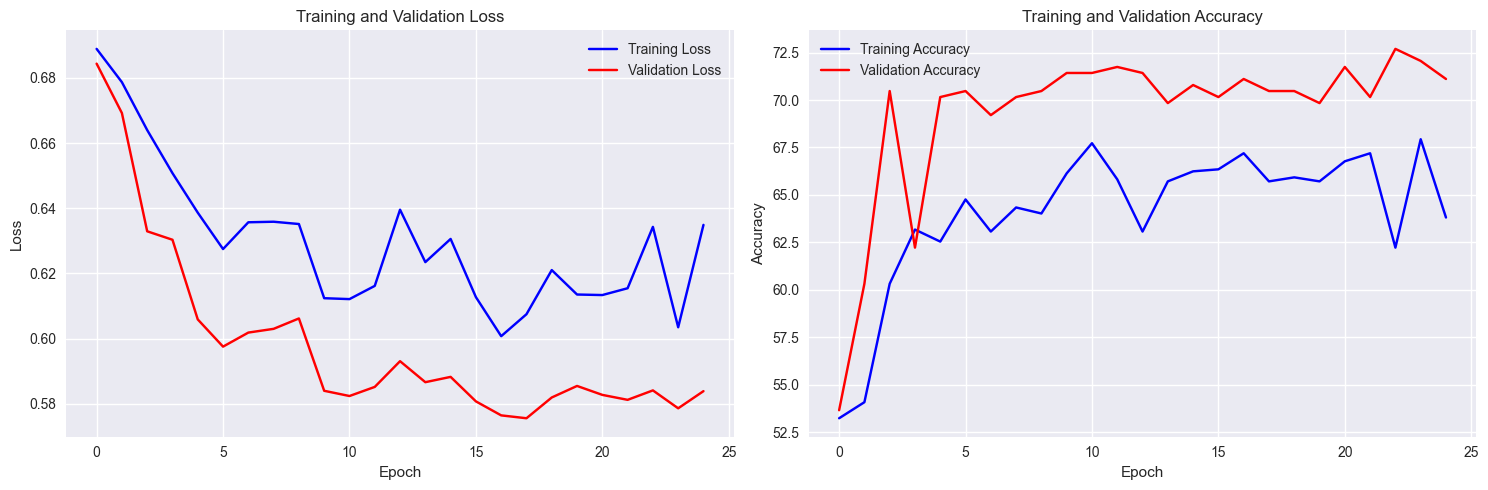

In [26]:
plot_training_history(hybrid_history)

In [4]:
def evaluate_multimodal_model(model, test_loader, device, label_encoder=None):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, text_embeddings, targets in tqdm(test_loader, desc='Evaluating'):
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            
            # Handle target encoding
            if label_encoder is not None:
                targets = torch.tensor(label_encoder.transform(targets), dtype=torch.long)
            else:
                targets = torch.tensor(targets, dtype=torch.long)
            
            # Forward pass
            outputs = model(images, text_embeddings)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    # Calculate metrics
    results = {
        'accuracy': accuracy_score(all_targets, all_preds),
        'f1': f1_score(all_targets, all_preds, average='weighted'),
        'precision': precision_score(all_targets, all_preds, average='weighted'),
        'recall': recall_score(all_targets, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_targets, all_preds),
        'classification_report': classification_report(all_targets, all_preds)
    }
    
    return results

In [20]:
# Load the state dict

model.to(device)

model_name = 'hybrid_multimodal_best_f1'
results = {}
state_dict = torch.load('models/hybrid_multimodal_best_f1.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval()  # set to evaluation mode

# Evaluate on test set
hybrid_test_results = evaluate_multimodal_model(
    model=model,
    test_loader=test_loader,
    device=device,
    label_encoder=label_encoder
)
results[model_name] = hybrid_test_results

# Print results
print("\nTest Set Results:")
print(f"Accuracy: {hybrid_test_results['accuracy']:.4f}")
print(f"F1 Score: {hybrid_test_results['f1']:.4f}")
print(f"Precision: {hybrid_test_results['precision']:.4f}")
print(f"Recall: {hybrid_test_results['recall']:.4f}")
print("\nClassification Report:")
print(hybrid_test_results['classification_report'])

Evaluating: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Test Set Results:
Accuracy: 0.6921
F1 Score: 0.6878
Precision: 0.6940
Recall: 0.6921

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.58      0.63       146
           1       0.68      0.79      0.73       169

    accuracy                           0.69       315
   macro avg       0.69      0.68      0.68       315
weighted avg       0.69      0.69      0.69       315



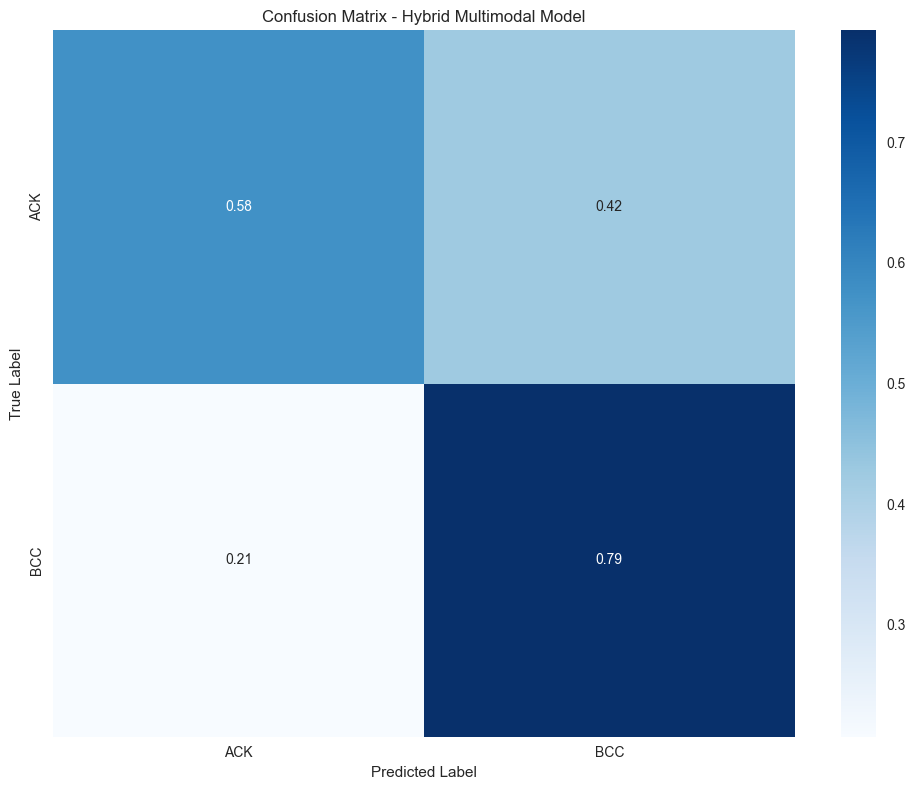

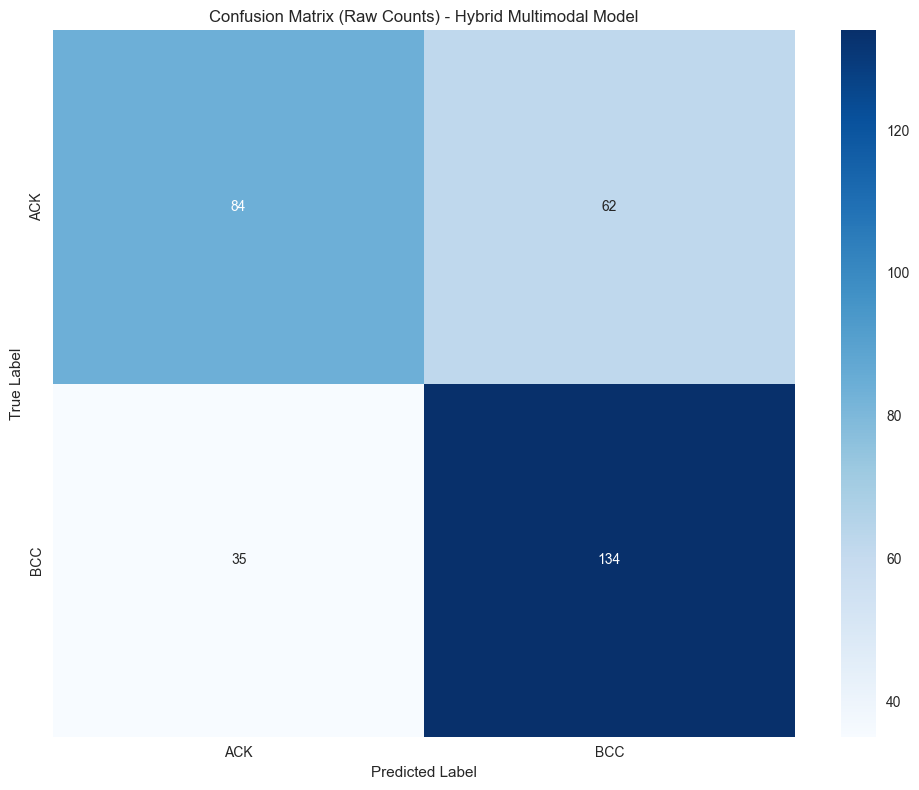

In [25]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = hybrid_test_results['confusion_matrix']

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(
    cm_normalized, 
    annot=True, 
    cmap='Blues',
    fmt='.2f',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title('Confusion Matrix - Hybrid Multimodal Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Also show raw counts
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    cmap='Blues',
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.title('Confusion Matrix (Raw Counts) - Hybrid Multimodal Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()